In [1]:
import sys, os, glob, scipy, sqlite3, json, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

In [2]:
# Style
import matplotlib.style as style
style.use('seaborn-poster') #sets the size of the charts
style.use('seaborn-white')
sns.set_palette('tab10')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = "Helvetica"

### Load data

In [3]:
baseDir = os.path.realpath('../..')
print(baseDir)
sys.path.append('/'.join(os.path.realpath('..').split('/')[:4]) + '/Python')
import FigureTools

/Users/jeroen/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Code_share/NHB_motives_structure/Study2_EyeTracking


In [6]:
gameDat = pd.read_csv(baseDir+'/Data/gameDat_study2.csv',index_col=0)
gameDat = gameDat.rename(columns = {'ConfidenceNum':'Confidence','ScoreNum':'Score'})
gameDat.head()

,sub,subID,Block,Player,Type,Variant,Type_Total,Trial,S,T,GameType,Colors,CorrAns,GivenAns,Confidence,Score,RT_radio,RT_submit,SelfReport
0,5,5005,0,N.N.,opt,nat,opt_nat,0,0,12,PD,"['Not', 'Defined']",def,def,86,1,8631,10443,not defined
1,5,5005,0,N.N.,opt,nat,opt_nat,1,7,5,HG,"['Not', 'Defined']",coop,coop,70,1,3639,5183,not defined
2,5,5005,0,N.N.,opt,nat,opt_nat,2,10,12,SG,"['Not', 'Defined']",def,coop,52,0,4796,6608,not defined
3,5,5005,0,N.N.,opt,nat,opt_nat,3,3,5,SH,"['Not', 'Defined']",coop,def,52,0,3840,5502,not defined
4,5,5005,0,N.N.,opt,nat,opt_nat,4,0,8,SH,"['Not', 'Defined']",coop,coop,54,1,3806,6322,not defined


In [7]:
print('%i participants found'%len(gameDat['subID'].unique()))

50 participants found


In [8]:
firstType = gameDat.loc[(gameDat['Trial']==0) & (gameDat['Block']==0), ['subID','Type_Total']].reset_index(drop=True)
firstType.columns = ['subID','FirstType']
thirdType = gameDat.loc[(gameDat['Trial']==0) & (gameDat['Block']==2), ['subID','Type_Total']].reset_index(drop=True)
thirdType.columns = ['subID','ThirdType']
gameDat = gameDat.merge(firstType,on='subID').merge(thirdType,on='subID')
gameDat.head()

,sub,subID,Block,Player,Type,Variant,Type_Total,Trial,S,T,...,Colors,CorrAns,GivenAns,Confidence,Score,RT_radio,RT_submit,SelfReport,FirstType,ThirdType
0,5,5005,0,N.N.,opt,nat,opt_nat,0,0,12,...,"['Not', 'Defined']",def,def,86,1,8631,10443,not defined,opt_nat,pess_inv
1,5,5005,0,N.N.,opt,nat,opt_nat,1,7,5,...,"['Not', 'Defined']",coop,coop,70,1,3639,5183,not defined,opt_nat,pess_inv
2,5,5005,0,N.N.,opt,nat,opt_nat,2,10,12,...,"['Not', 'Defined']",def,coop,52,0,4796,6608,not defined,opt_nat,pess_inv
3,5,5005,0,N.N.,opt,nat,opt_nat,3,3,5,...,"['Not', 'Defined']",coop,def,52,0,3840,5502,not defined,opt_nat,pess_inv
4,5,5005,0,N.N.,opt,nat,opt_nat,4,0,8,...,"['Not', 'Defined']",coop,coop,54,1,3806,6322,not defined,opt_nat,pess_inv


In [9]:
gtOrder = ['HG','SG','SH','PD']
roundOrder = range(4)
ptOrder = ['opt_nat','pess_nat','opt_inv','pess_inv']

In [10]:
def ttest_1samp(dat, popmean = .5, verbose = True):
    if verbose:
        print('SD: ',np.std(dat))
        print('Stats:')
    stats = scipy.stats.ttest_1samp(dat, popmean = popmean)
    if verbose:
        print(stats)
        print('Cohen d:')
    coh_d = (np.mean(dat) - popmean)/np.std(dat)
    if verbose:
        print(coh_d)
    return(stats, coh_d)

def ttest_2samp(dat1, dat2):
    print('SD dat 1: ',np.std(dat1))
    print('SD dat 2: ',np.std(dat2))
    print('Stats:')
    stats = scipy.stats.ttest_ind(dat1, dat2)
    print(stats)
    print('Cohen d:')
    nx = len(dat1)
    ny = len(dat2)
    dof = nx + ny - 2
    coh_d = ((np.mean(dat1) - np.mean(dat2)) /
             np.sqrt(((nx-1)*np.std(dat1, ddof=1) ** 2 + (ny-1)*np.std(dat2, ddof=1) ** 2) / dof))
    print(coh_d)
    return(stats, coh_d)

# Supplemental Results 6 part 1: replicating the behavioral effects in study 2

## Overall performance against chance

In [13]:
gameDat.groupby('subID',as_index=False).mean()['Score'].mean()

0.6271875

In [14]:
ttest_1samp(gameDat.groupby('subID',as_index=False).mean()['Score'], .5)

SD:  0.09250527856560403
Stats:
Ttest_1sampResult(statistic=9.624450775191141, pvalue=7.061977943310414e-13)
Cohen d:
1.37492153931302


(Ttest_1sampResult(statistic=9.624450775191141, pvalue=7.061977943310414e-13),
 1.37492153931302)

## Overall performance by player type

In [15]:
gameDat.columns

Index(['sub', 'subID', 'Block', 'Player', 'Type', 'Variant', 'Type_Total',
       'Trial', 'S', 'T', 'GameType', 'Colors', 'CorrAns', 'GivenAns',
       'Confidence', 'Score', 'RT_radio', 'RT_submit', 'SelfReport',
       'FirstType', 'ThirdType'],
      dtype='object')

(0, 1.4)

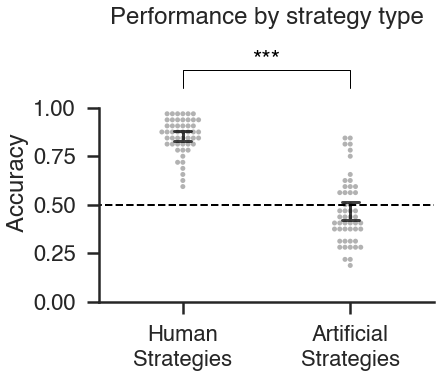

In [17]:
sns.set_context('poster')
blockDat = gameDat[['subID','Type_Total','Type','Variant','Confidence','Score']
                  ].groupby(['subID','Variant']).mean().reset_index()
fig, ax = plt.subplots(1,1,figsize=[6,5])
sns.barplot(data=blockDat,x='Variant',y='Score', ax=ax, errwidth = 3, capsize=.1,
            order=['nat','inv'],alpha=0)
sns.swarmplot(data=blockDat,x='Variant',y='Score', ax=ax,
            order=['nat','inv'], alpha=.3, color = 'k')
ax.plot([-5,5],[.5,.5], 'k--', lw=2)
ax.set(ylim = [0,1.1], xlim = [-.5,1.5], xlabel = None, yticks = [0,.25,.5,.75,1],
       title = 'Performance by strategy type',
       xticklabels = ['Human\nStrategies', 'Artificial\nStrategies'], ylabel = 'Accuracy     ');
dat1 = blockDat.loc[blockDat['Variant']=='nat','Score'].values
dat2 = blockDat.loc[blockDat['Variant']=='inv','Score'].values
stats = scipy.stats.ttest_rel(dat2,dat1)
FigureTools.add_sig_markers(ax, relationships=[[0,1,stats[1]]])
sns.despine(top=True,right=True)
ax.spines['left'].set_bounds(0,1)
ax.set_ylim([0,1.4])

In [18]:
print(np.std(dat1), np.std(dat2))
ttest_1samp(dat2-dat1, 0)

0.09045026257562773 0.16851372347675428
SD:  0.15955994171470483
Stats:
Ttest_1sampResult(statistic=-16.945042539776924, pvalue=3.9594312009069757e-22)
Cohen d:
-2.420720362825275


(Ttest_1sampResult(statistic=-16.945042539776924, pvalue=3.9594312009069757e-22),
 -2.420720362825275)